In [65]:
import pandas as pd
from pathlib import Path
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew, kurtosis

Question 1 --> Within Transforms, Pooled etc 

In [17]:
# Question 1 --> create the between-transformed and one-way within-transformed versions of each variable in the dataset. 
# getting teh path to my data set 

final_data_path = Path("/Users/lorenzouberti/Desktop/Panel-Data-Project-Financial-Econometrics/Data")
df_var_between = pd.read_excel(final_data_path / "final_panel_dataset.xlsx")
df_var_between = df_var_between.drop(columns=["pop"])
# sorting the data set by country and year
df_var_between = df_var_between.sort_values(["country", "year"])
# getting the list of variables to be transformed
variables = [ 'gdppc', 'labour_productivity', 'cpi', 'trade_openness', 'liquid_liabilities', 'mcap_gdp', 'bank_loans_gdp' ]
df_var_between['gdppc'] = np.log(df_var_between['gdppc'])
df_var_between['labour_productivity'] = np.log(df_var_between['labour_productivity'])
df_var_between['cpi'] = np.log(df_var_between['cpi'])

for var in variables:   # Between transformation
    df_var_between[f'{var}_between'] = df_var_between.groupby('country')[var].transform('mean')
    
    # One-way Within transformation
    df_var_between[f'{var}_within'] = df_var_between[var] - df_var_between.groupby('country')[var].transform('mean')

rows = []

for var in variables:
    # Total pooled variance
    pooled_variance = df_var_between[var].var(ddof=1)

    # Between variance 
    var_between = df_var_between[f'{var}_between'].var(ddof=1)

    # Within variance 
    var_within = df_var_between[f'{var}_within'].var(ddof=1)

    #Shares of total variance --> basically so no zero var
    if pooled_variance != 0 and not np.isnan(pooled_variance):
        share_between = var_between / pooled_variance
        share_within = var_within / pooled_variance
    else:
        share_between = np.nan
        share_within = np.nan

    rows.append({
        "variable": var,
        "var_total_pooled": pooled_variance,
        "var_between": var_between,
        "var_within": var_within,
        "share_between": share_between,
        "share_within": share_within
    })

# vardecomp tabel 
var_decomp = pd.DataFrame(rows).set_index("variable")

# Nice printing
pd.set_option("display.float_format", "{:,.4f}".format)
print("\n=== Variance decomposition ===\n")
print(var_decomp)



=== Variance decomposition ===

                     var_total_pooled  var_between  var_within  share_between  \
variable                                                                        
gdppc                          0.8785       0.0980      0.7805         0.1115   
labour_productivity            1.1241       0.1079      1.0162         0.0960   
cpi                           18.9989       3.4977     15.5012         0.1841   
trade_openness                 0.4182       0.3390      0.0791         0.8107   
liquid_liabilities             0.0664       0.0125      0.0539         0.1877   
mcap_gdp                       0.1390       0.0447      0.0944         0.3212   
bank_loans_gdp                 0.1293       0.0602      0.0691         0.4654   

                     share_within  
variable                           
gdppc                      0.8885  
labour_productivity        0.9040  
cpi                        0.8159  
trade_openness             0.1893  
liquid_liabilities   

Question 2 --> Distributions Plots, etc  --> Model is: 

In [35]:
# In the study as one of teh explanatory varibles they create a 5 year lagged GDP per capita variable.
# Therefore, prior to plotting the distributions, we create this variable in the final data set.
df_Final = pd.read_excel(final_data_path / "final_panel_dataset.xlsx")
df_Final = df_Final.sort_values(["country", "year"])
df_Final = df_Final[['country', 'year', 'gdppc', 'labour_productivity', 'cpi', 'trade_openness', 'liquid_liabilities', 'mcap_gdp', 'bank_loans_gdp']]
df_Final = df_Final.sort_values(["country", "year"])

# Logging GDP per capita first
df_Final['ln_gdppc'] = np.log(df_Final['gdppc'])
df_Final["ln_gdppc_lag5"] = df_Final.groupby("country")["ln_gdppc"].shift(5)
# Creating the 5 year lagged GDP per capita growth variable
df_Final["ln_gdp_growth_5y"] = df_Final["ln_gdppc"] - df_Final["ln_gdppc_lag5"]

# Doing of rthe alternative dependent variable: labour productivity growth
df_Final['ln_labour_productivity'] = np.log(df_Final['labour_productivity'])
df_Final["ln_labour_productivity_lag5"] = df_Final.groupby("country")["ln_labour_productivity"].shift(5)
df_Final["ln_labour_productivity_growth_5y"] = df_Final["ln_labour_productivity"] - df_Final["ln_labour_productivity_lag5"]

# taking teh logarithm of the other variables as well
df_Final['ln_cpi'] = np.log(df_Final['cpi'])
df_Final['ln_trade_openness'] = np.log(df_Final['trade_openness'])








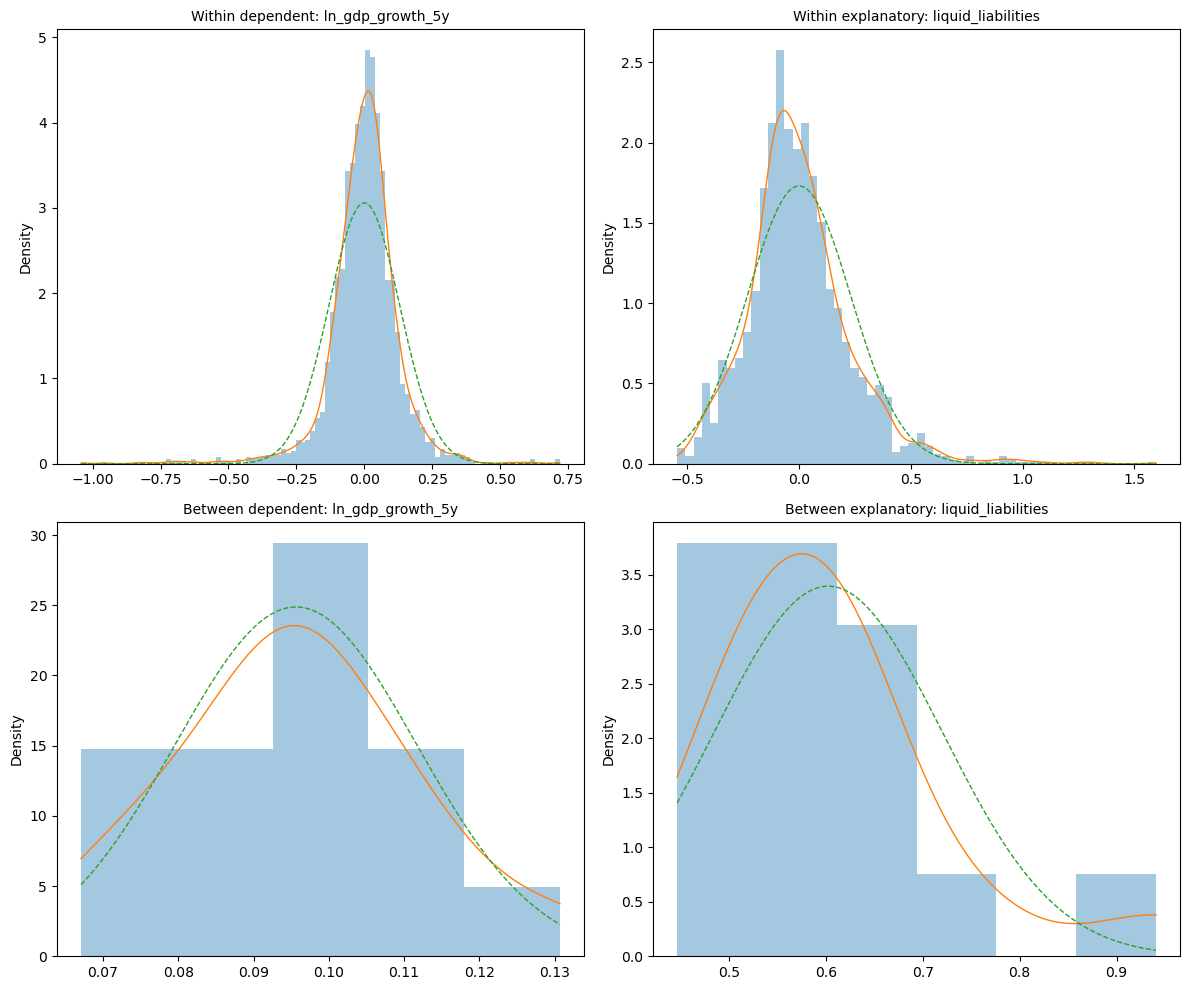


Summary statistics for within / between variables:
                  variable    n   mean     sd  skewness  kurtosis  high_leverage(|z|>3)
   ln_gdp_growth_5y_within 2144 0.0000 0.1304   -1.1084   12.7469                    37
 liquid_liabilities_within 2144 0.0000 0.2305    1.1249    6.8723                    23
  ln_gdp_growth_5y_between   16 0.0956 0.0160    0.2492    2.9390                     0
liquid_liabilities_between   16 0.6026 0.1175    1.4965    5.4128                     0


In [ ]:
# Defining my Dependent and Explanatory Variables
Dependent_Variables_Growth = ['ln_gdp_growth_5y','ln_labour_productivity_growth_5y' ]
Explanatory_Variables = ['ln_gdppc_lag5', 'ln_labour_productivity_lag5', 'liquid_liabilities', 'mcap_gdp', 'bank_loans_gdp']
Control_Variables = ['ln_cpi', 'ln_trade_openness']

# defining my individuals, time, dependent and explanatory variables

individuals = df_Final['country']
time = df_Final['year']
dep_var_col = 'ln_gdp_growth_5y'
exp_var_col = 'liquid_liabilities'
cols_to_keep = ["country", "year", dep_var_col, exp_var_col, "ln_cpi", "ln_trade_openness"]
df_Final_defined = df_Final[cols_to_keep].dropna()

# computing the within and between transforms 

df_Final_defined["dep_var_col_mean_i"] = df_Final_defined.groupby(individuals)[dep_var_col].transform("mean")
df_Final_defined["exp_var_col_mean_i"] = df_Final_defined.groupby(individuals)[exp_var_col].transform("mean")

df_Final_defined["dep_var_col_within"] = df_Final_defined[dep_var_col] - df_Final_defined['dep_var_col_mean_i']
df_Final_defined["exp_var_col_within"] = df_Final_defined[exp_var_col] - df_Final_defined['exp_var_col_mean_i']

between_df_Final_defined = (
    df_Final_defined
    .groupby("country")
    .agg(
        dep_var_col_between=(dep_var_col, 'mean'),
        exp_var_col_between=(exp_var_col, 'mean')
    )
    .reset_index()
)

def plot_dist_subplot(ax, values, title, bins='auto'):
    # Convert to numeric safely, drop NaN/inf
    values = pd.to_numeric(values, errors='coerce')
    values = values[np.isfinite(values)]

    if len(values) == 0:
        ax.set_title(f"No valid data for {title}", fontsize=10)
        return

    mu = values.mean()
    sigma = values.std(ddof=1)

    # Histogram
    ax.hist(values, bins=bins, density=True, alpha=0.4)

    # KDE
    kde = gaussian_kde(values)
    xmin, xmax = values.min(), values.max()
    x_grid = np.linspace(xmin, xmax, 500)
    ax.plot(x_grid, kde(x_grid), linewidth=1)

    # Normal pdf
    if sigma > 0:
        normal_pdf = (
            1 / (np.sqrt(2 * np.pi) * sigma)
            * np.exp(-0.5 * ((x_grid - mu) / sigma) ** 2)
        )
        ax.plot(x_grid, normal_pdf, linestyle="--", linewidth=1)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("Density")


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: within dependent
plot_dist_subplot(
    axs[0, 0],
    df_Final_defined["dep_var_col_within"],
    f"Within dependent: {dep_var_col}"
)

# Top-right: within explanatory
plot_dist_subplot(
    axs[0, 1],
    df_Final_defined["exp_var_col_within"],
    f"Within explanatory: {exp_var_col}"
)

# Bottom-left: between dependent
plot_dist_subplot(
    axs[1, 0],
    between_df_Final_defined["dep_var_col_between"],
    f"Between dependent: {dep_var_col}"
)

# Bottom-right: between explanatory
plot_dist_subplot(
    axs[1, 1],
    between_df_Final_defined["exp_var_col_between"],
    f"Between explanatory: {exp_var_col}"
)

plt.tight_layout()
plt.show()

def compute_stats(values, name):
    values = pd.to_numeric(values, errors='coerce')
    values = values[np.isfinite(values)]

    mu = values.mean()
    sd = values.std(ddof=1)
    sk = skew(values)
    kt = kurtosis(values, fisher=False)  # normal => 3

    # "High leverage" defined as |z| > 3
    if sd > 0:
        z = (values - mu) / sd
        high_lev = np.sum(np.abs(z) > 3)
    else:
        high_lev = 0

    return {
        "variable": name,
        "n": len(values),
        "mean": mu,
        "sd": sd,
        "skewness": sk,
        "kurtosis": kt,
        "high_leverage(|z|>3)": high_lev,
    }

stats_list = []
stats_list.append(
    compute_stats(df_Final_defined["dep_var_col_within"],
                  f"{dep_var_col}_within")
)
stats_list.append(
    compute_stats(df_Final_defined["exp_var_col_within"],
                  f"{exp_var_col}_within")
)
stats_list.append(
    compute_stats(between_df_Final_defined["dep_var_col_between"],
                  f"{dep_var_col}_between")
)
stats_list.append(
    compute_stats(between_df_Final_defined["exp_var_col_between"],
                  f"{exp_var_col}_between")
)

stats_df = pd.DataFrame(stats_list)
print("\nSummary statistics for within / between variables:")
print(stats_df.to_string(index=False))




